In [1]:

import os
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torch
from torchvision import transforms
from code.classifier import PneumoniaClassifier, Config
import matplotlib.pyplot as plt
import numpy as np



In [2]:

# Load the TensorBoard extension
%reload_ext tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
# Enable CUDA Launch Blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set float32 matrix multiplication precision to 'medium' to utilize Tensor Cores
torch.set_float32_matmul_precision('medium')
torch.serialization.add_safe_globals([Compose, Resize, set, Config, InterpolationMode, ToTensor, Normalize, RandomHorizontalFlip])

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Fri Nov 29 22:49:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   49C    P8             14W /  285W |    4075MiB /  12282MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
from torchvision import transforms


config = Config(
    backbone_name="resnet18",
    transfer_learning=True,
    learning_rate=1e-4,
    batch_size=20,
    max_epochs=100,
    weight_decay=1e-4,
    dropout=0.2,
    num_workers=31,
    model_name="ResNet18_transfer_weighted_upscale_trans",
    version="001",
    optimizer_name = "sgd",
    use_class_weights=True,
    image_res=1000
)
model = PneumoniaClassifier(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:


model.train_model()
torch.save(model.state_dict(), f"../models/{config.model_name}_final.pt")

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\aszab\Documents\Studium\Modules\ComputerScienceProject\MedicalImaging\pneumonia_detection\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name              | Type            | Params | Mode 
--------------------------------------------------------------
0 | accuracy          | BinaryAccuracy  | 0      | train
1 | precision         | BinaryPrecision | 0      | train
2 | recall            | BinaryRecall    | 0      | train
3 | f1                | BinaryF1Score   | 0      | train
4 | feature_extractor | Sequential      | 11.2 M | train
5 | dropout           | Dropout         | 0      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [7]:
# Testing
print("Testing the models...")
checkpoint_path = "../checkpoints/ResNet18_transfer.ckpt"
test_metadata = model.test_model(checkpoint_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing the models...
Testing DataLoader 0: 100%|██████████| 44/44 [00:16<00:00,  2.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.9385665655136108
      test_acc_step          0.937599241733551
      test_f1_epoch         0.9572784900665283
      test_f1_step          0.6797008514404297
        test_loss           0.17992357909679413
  test_precision_epoch       0.971107542514801
   test_precision_step      0.6642014980316162
    test_recall_epoch       0.9438377618789673
    test_recall_step        0.7175719738006592
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [8]:
# Initialize the models
#models = PneumoniaClassifier(config, transform)
# Test the models
#metadata = models.test_model(f"../checkpoints/{config.model_name}.ckpt")
#model = torch.load(f"../models/{config.model_name}.pt")
#model.eval()
#model.test_model()
#
## Print the metadata
#print(metadata)

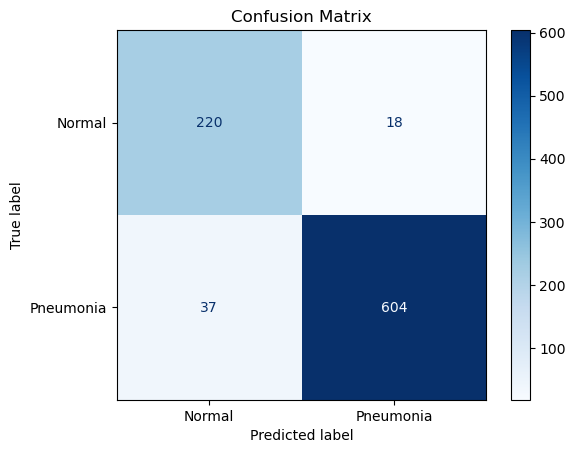

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.cuda()  # Move data to GPU if available
            labels = labels.cuda()
            preds = torch.argmax(model(data), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call this after training/testing
plot_confusion_matrix(model, model.test_loader, class_names=["Normal", "Pneumonia"])

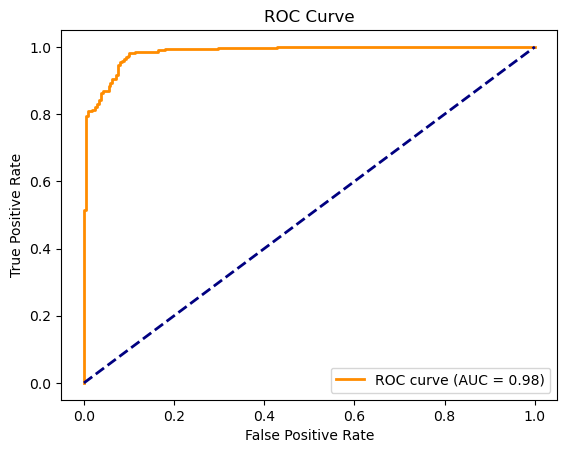

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc(model, dataloader):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    model.eval()
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.cuda()
            labels = labels.cuda()
            preds = model(data)
            probs = torch.softmax(preds, dim=1)[:, 1]  # Probabilities for class 1
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Call this after training/testing
plot_roc_auc(model, model.test_loader)

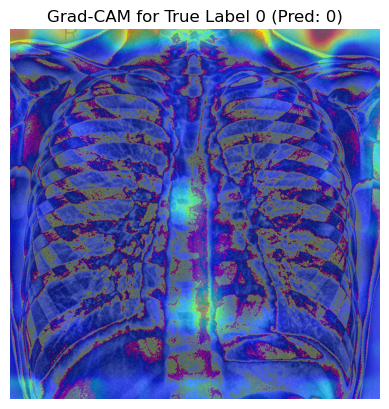

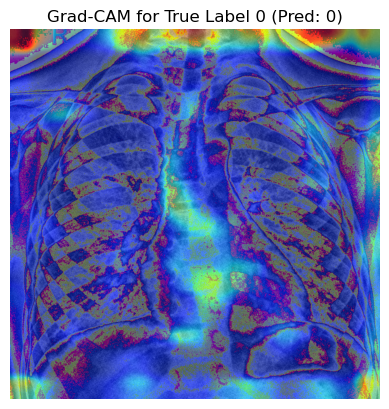

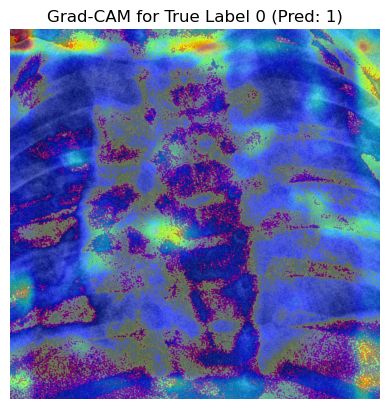

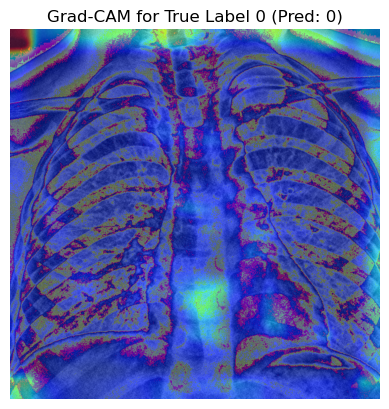

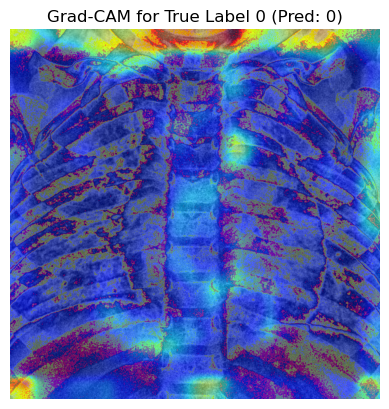

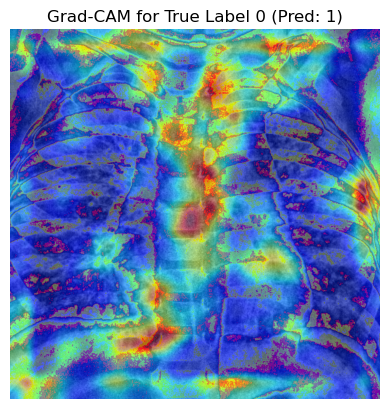

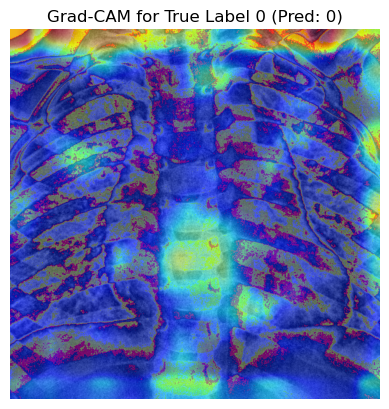

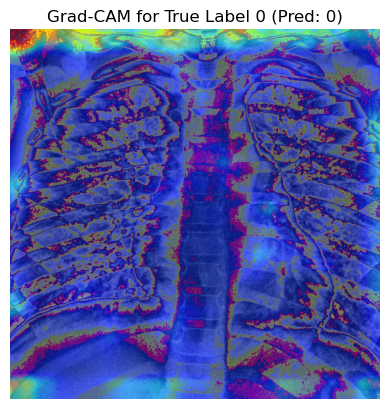

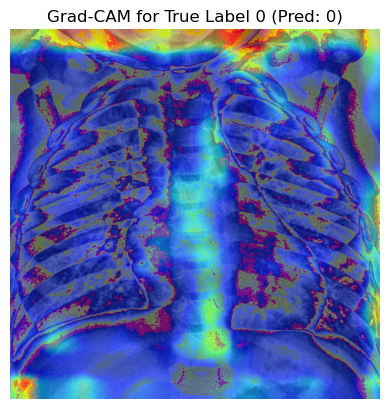

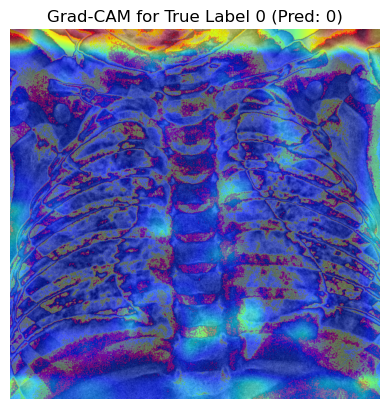

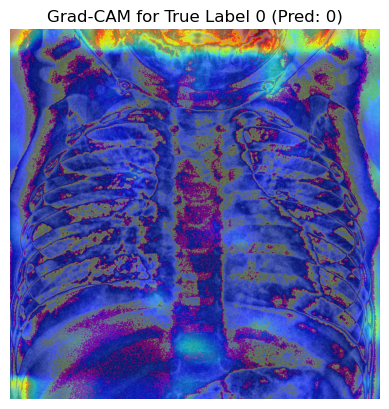

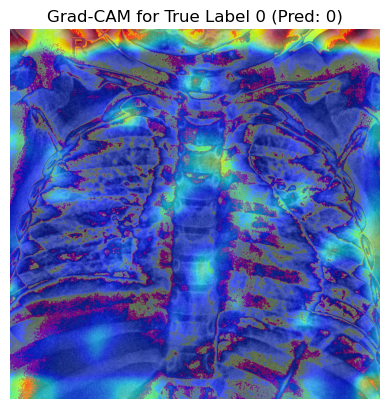

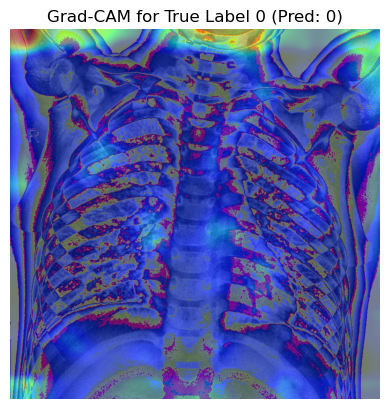

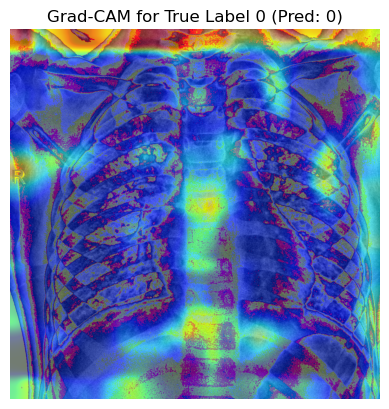

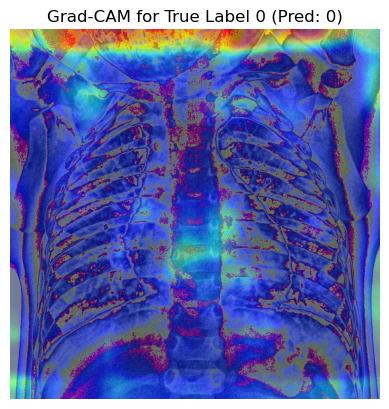

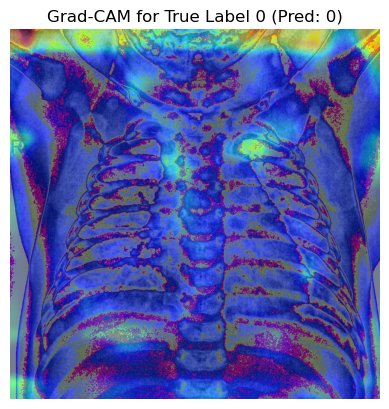

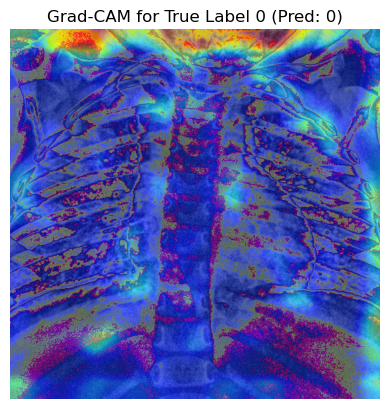

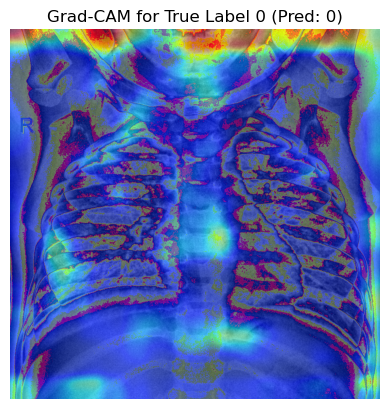

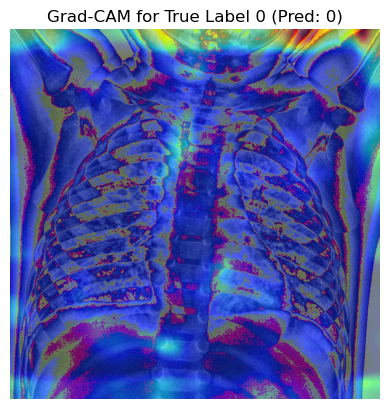

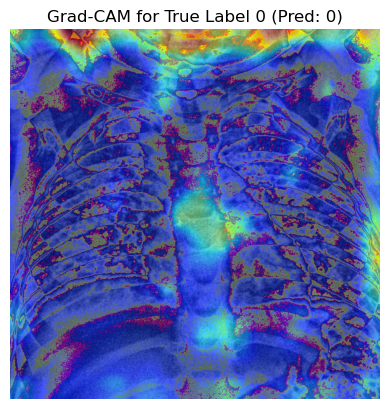

In [11]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import torch
import matplotlib.pyplot as plt


def visualize_gradcam(model, dataloader, target_layer="feature_extractor.8"):
    model.eval()  # Set the model to evaluation mode

    # Enable gradients for Grad-CAM
    for param in model.parameters():
        param.requires_grad = True

    # Initialize Grad-CAM with the target layer
    cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

    # Pick one batch from the dataloader
    data, labels = next(iter(dataloader))
    data = data.cuda()
    labels = labels.cuda()

    # Enable gradient computation
    with torch.set_grad_enabled(True):
        # Process each image individually
        for i in range(len(data)):
            image = data[i].unsqueeze(0)  # Add batch dimension
            label = labels[i].item()

            # Forward pass for the single image
            preds = model(image)
            class_idx = preds.argmax(dim=1).item()

            try:
                # Generate CAM for the predicted class
                cam = cam_extractor(class_idx, preds)

                # Extract heatmap
                heatmap = cam[target_layer] if isinstance(cam, dict) else cam[0]

                if heatmap.dim() == 3:  # Reduce multi-channel heatmap
                    heatmap = heatmap.mean(dim=0)

                # Convert the image and heatmap to PIL images
                original_image = to_pil_image(image.squeeze(0).cpu())
                heatmap_image = to_pil_image(heatmap, mode="F")

                # Overlay heatmap on the original image
                result = overlay_mask(original_image, heatmap_image, alpha=0.5)
                plt.imshow(result)
                plt.title(f"Grad-CAM for True Label {label} (Pred: {class_idx})")
                plt.axis("off")
                plt.show()

            except Exception as e:
                print(f"Error processing image {i}: {e}")
                continue


# Call this function after training
visualize_gradcam(model, model.test_loader, target_layer="feature_extractor.7")
